### Process for handling chessData

In [156]:
import pandas as pd
import numpy as np
from chess import Board

from bot_model import evaluator, board2d_embed, bitboard_embed

In [157]:
df = pd.read_csv('data\\random_evals.csv', nrows= 10000)
df.head()

,FEN,Evaluation
0,rnbqkb1r/pppppppp/B4n2/8/4P3/8/PPPP1PPP/RNBQK1...,-459
1,rnbqkb1r/pppppppp/5n2/1B6/4P3/8/PPPP1PPP/RNBQK...,-125
2,rnbqkbnr/p1pppppp/8/1p6/4P3/8/PPPP1PPP/RNBQKBN...,+198
3,rnbqkb1r/pppppppp/5n2/8/4P3/7N/PPPP1PPP/RNBQKB...,-155
4,rnbqkbnr/ppppp1pp/8/5p2/4P3/8/PPPP1PPP/RNBQKBN...,+209


In [158]:
# mask method
mask = df['Evaluation'].str.contains('#')

# ones with the checkmates
removed_df = df[mask == True]

# normal position
filtered_df = df[mask == False]
filtered_df.head()


,FEN,Evaluation
0,rnbqkb1r/pppppppp/B4n2/8/4P3/8/PPPP1PPP/RNBQK1...,-459
1,rnbqkb1r/pppppppp/5n2/1B6/4P3/8/PPPP1PPP/RNBQK...,-125
2,rnbqkbnr/p1pppppp/8/1p6/4P3/8/PPPP1PPP/RNBQKBN...,+198
3,rnbqkb1r/pppppppp/5n2/8/4P3/7N/PPPP1PPP/RNBQKB...,-155
4,rnbqkbnr/ppppp1pp/8/5p2/4P3/8/PPPP1PPP/RNBQKBN...,+209


In [159]:
board_data, targets = None, None

def game_board(fen):
    game = Board(fen)
    return bitboard_embed(game)


# board_data = filtered_df['FEN'].apply(game_board).to_list()
targets = filtered_df['Evaluation'].to_numpy(dtype= int)
print(targets[0:5])

[-459 -125  198 -155  209]


In [160]:
print(f'data_range: {targets.max()} <-> {targets.min()}')
print(f'data_range: {filtered_df.max()} <-> {filtered_df.min()}')

data_range: 8138 <-> -8226
data_range: FEN           rr6/ppQ2pk1/2p1q1p1/4p3/8/2P2R2/5PP1/4R1K1 w -...
Evaluation                                                    0
dtype: object <-> FEN           1B1r1rk1/p4ppp/2p2n2/2q5/2p5/1P3NPb/P1Q2P1P/RN...
Evaluation                                                   +1
dtype: object


In [161]:
removed_df.loc[df['Evaluation'].str.contains('#-'), 'Evaluation'] = '-20000'  
removed_df.loc[df['Evaluation'].str.contains('#+'), 'Evaluation'] = '+20000'  
removed_df.head()

C:\Users\anshu_r9i5971\AppData\Local\Temp\ipykernel_29904\1924023408.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  removed_df.loc[df['Evaluation'].str.contains('#-'), 'Evaluation'] = '-20000'
C:\Users\anshu_r9i5971\AppData\Local\Temp\ipykernel_29904\1924023408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  removed_df.loc[df['Evaluation'].str.contains('#+'), 'Evaluation'] = '+20000'


,FEN,Evaluation
1088,r4rk1/pb2p1bp/6p1/2PqBp2/8/8/1P3PPP/RN1Q1RK1 b...,+20000
1089,r4rk1/pb2p1bp/6p1/B1Pqpp2/8/8/1P3PPP/RN1Q1RK1 ...,+20000
1090,r4rk1/pb2p1bp/6p1/2Pqpp2/3B4/8/1P3PPP/RN1Q1RK1...,+20000
1091,r4rk1/pb2p1bp/6p1/2Pqpp2/1B6/8/1P3PPP/RN1Q1RK1...,+20000
1092,r4rk1/pb2p1bp/6p1/2Pqpp2/8/8/1P1B1PPP/RN1Q1RK1...,+20000


In [162]:
df.loc[df['Evaluation'].str.contains('#-'), 'Evaluation'] = '-20000'  
df.loc[df['Evaluation'].str.contains('#+'), 'Evaluation'] = '+20000'  

df['Evaluation'] = pd.to_numeric(df['Evaluation'])

In [163]:
def Robust_Scaling():
    median = df['Evaluation'].median()
    iqr = df['Evaluation'].quantile(0.75) - df['Evaluation'].quantile(0.25)

    df['scaled'] = (df['Evaluation'] - median) / iqr

def z_score():
    df['scaled'] = (df['Evaluation'] - df['Evaluation'].mean()) / df['Evaluation'].std()

def min_max_Scaling():
    # REJECTED
    df['scaled'] = (df['Evaluation'] - df['Evaluation'].min()) / (df['Evaluation'].max() - df['Evaluation'].min())

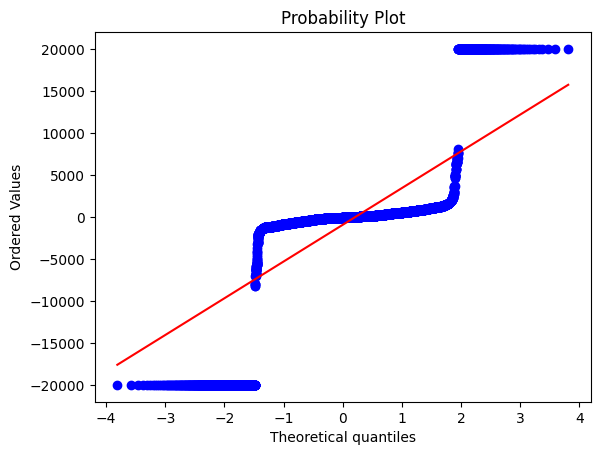

In [164]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Q-Q plot
stats.probplot(df['Evaluation'], dist="norm", plot=plt)
plt.show()

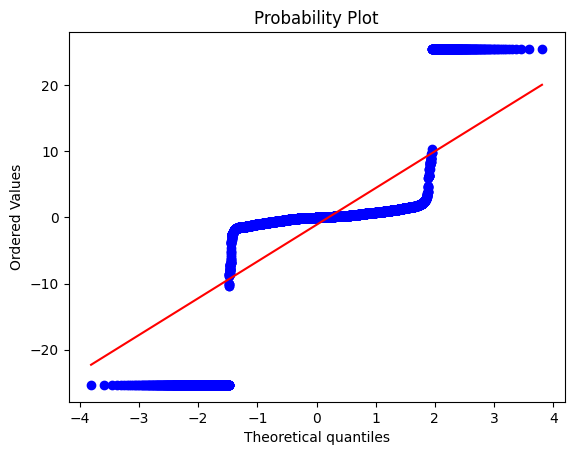

In [167]:
Robust_Scaling()

# Q-Q plot
stats.probplot(df['scaled'], dist="norm", plot=plt)
plt.show()

In [166]:
print(df.max())
print(df.min())

FEN           rr6/ppQ2pk1/2p1q1p1/4p3/8/2P2R2/5PP1/4R1K1 w -...
Evaluation                                                20000
scaled                                                 3.402438
dtype: object
FEN           1B1r1rk1/p4ppp/2p2n2/2q5/2p5/1P3NPb/P1Q2P1P/RN...
Evaluation                                               -20000
scaled                                                -3.098599
dtype: object
